# Think Like a Machine - Chapter 5
Logistic Regression
===================

**ACKNOWLEDGEMENT**

**A lot of the code in this notebook is from John D. Wittenauer's notebooks that cover the exercises in Andrew Ng's course on Machine Learning on Coursera. This is mostly Wittenauer's and Ng's work and acknowledged as such. I've also used some code from Sebastian Raschka's book *Python Machine Learning*. **

## The Problem
You're a student applying to an elite university. To be admitted, the university requires you to take 2 entrance exams. The university also publishes a dataset of the scores of students who took both exams and for each student whether he or she was accpeted. Knowing your scores on the two entrance exams, what is your probability of being accepted to this elite university?

## Exercise 5-1
Create a list of 5 problems that fit the same structure as the problem above. For example, you could be a physician, a recruiter, head of sales, ...

## Load the Data

In [75]:
# Use the functions from another notebook in this notebook
%run SharedFunctions.ipynb

In [57]:
# Import our usual libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import os
path = os.getcwd() + '/Data/ex2data1.txt'
data = pd.read_csv(path, header=None, names=['Exam 1', 'Exam 2', 'Admitted'])
data.head()

,Exam 1,Exam 2,Admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


## Visualize the Data

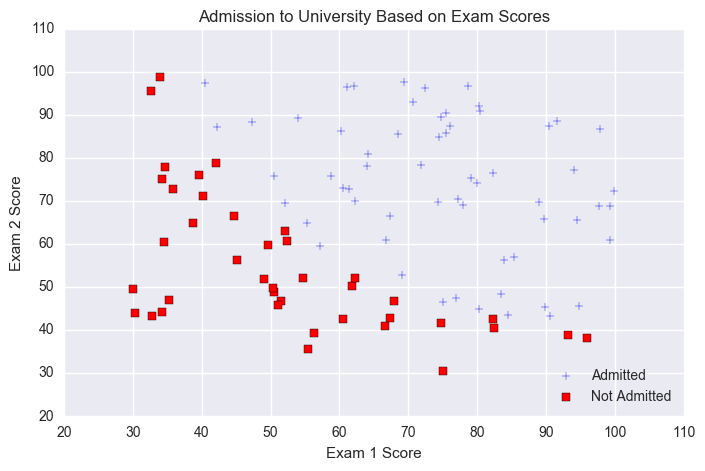

In [141]:
positive = data[data['Admitted'].isin([1])]
negative = data[data['Admitted'].isin([0])]

fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(positive['Exam 1'], positive['Exam 2'], s=30, c='b', marker='+', label='Admitted')
ax.scatter(negative['Exam 1'], negative['Exam 2'], s=30, c='r', marker='s', label='Not Admitted')
ax.legend(loc='lower right')
ax.set_xlabel('Exam 1 Score')
ax.set_ylabel('Exam 2 Score')
plt.title('Admission to University Based on Exam Scores')

Right away we see that this doesn't even look like a regular regression problem -- there are two classes -- Admitted and Not Admitted -- and we'd like to separate them. We need a technique for learning what class a student falls into based on his or her exam scores.

We'll start by trying to draw a line through the plot above that optimally separates the candidates who have been admitted from those who have not been admitted. We'll think like a machine to find the parameter values that define this line. The line is called a *decision boundary* -- depending on which side of the line a point falls, its fate is decided.

In [78]:
# A few examples of decision boundaries
#plot_decision_regions(data.iloc[:, 1:3].values, data.iloc[:,3].values, 'ppn')
## TO DO

Because the output of our classification is not a real number (unlike in regression where it can take on a value within a certain range of numbers), we need a function to take exam scores (or similar inputs) and produce two categories of output (say 0 for Not Admitted, and 1 for Admitted). The way to do this is to use the *sigmoid* function.

What the sigmoid function does is take an expression like the one we're familiar with below

$$h_{\theta}(x) = \theta_{0} x_{0} + \theta_{1} x_{1} + \theta_{2} x_{2}$$

and convert it to the following expression:

$$g(h_{\theta}(x)) = \frac{1}{1 + e^{-h_{\theta}(x)}}$$

where $e$ is the natural log. So what does the sigmoid function or sigmoid transformation look like?

In [7]:
# Define the sigmoid function or transformation
# NOTE: ALSO PUT INTO THE SharedFunctions notebook
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

<bound method AxesSubplot.plot of <matplotlib.axes._subplots.AxesSubplot object at 0x11a9ae450>>

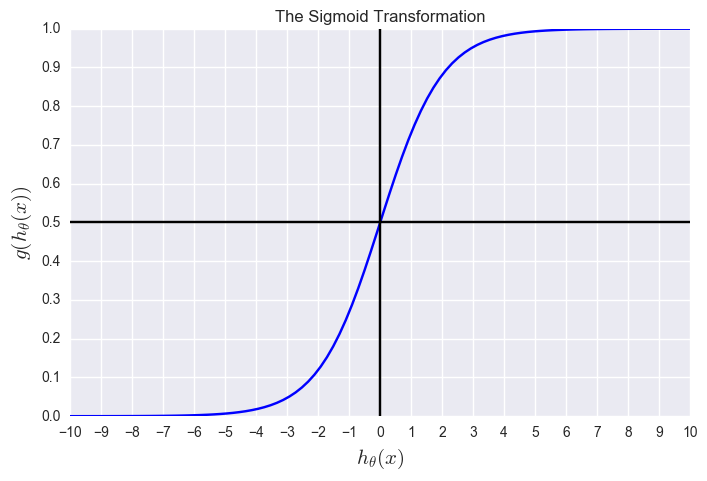

In [8]:
# Plot the sigmoid function
# Generate the values to be plotted
x_vals = np.linspace(-10,10,100)
y_vals = [sigmoid(x) for x in x_vals]

# Plot the values
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(x_vals, y_vals, 'blue')
# Draw some constant lines to aid visualization
plt.axvline(x=0, color='black')
plt.axhline(y=0.5, color='black')
plt.yticks(np.arange(0,1.1,0.1))
plt.xticks(np.arange(-10,11,1))
plt.xlabel(r'$h_{\theta}(x)$', fontsize=15)
plt.ylabel(r'$g(h_{\theta}(x))$', fontsize=15)
plt.title('The Sigmoid Transformation')
ax.plot

The beauty of the sigmoid transoformation is it gives us a way to take a variable with continuous values and transform it into a variable with just two values -- 0 or 1. The sigmoid can never be less than zero; nor can it be greater than 1. When $h_{\theta}(x)$ is around 6 or greater, the sigmoid is, for all practical purposes, equal to 1. Similarly, when $h_{\theta}(x)$ is around -6 or smaller, the sigmoid is for all practical purposes 0.

Many other functions can do this kind of 1 or 0 transformation -- a simple step function will do. The advantage of using a sigmoid is *the values can be read off as probabilities*.

## Steps 1 and 2: Define the Inputs and the Output
How do we find the line that separates the data? Let's begin by defining the inputs.

In [9]:
# add a ones column to the inputs - this makes the matrix multiplication work out easier
data.insert(0, 'Ones', 1)

# set X (training data) and y (target variable)
cols = data.shape[1]
X = data.iloc[:,0:cols-1]
y = data.iloc[:,cols-1:cols]

# convert to matrices
X = np.matrix(X.values)
y = np.matrix(y.values)

In [10]:
X.shape

(100, 3)

In [11]:
y.shape

(100, 1)

In [12]:
X[0:5,:]

matrix([[  1.        ,  34.62365962,  78.02469282],
        [  1.        ,  30.28671077,  43.89499752],
        [  1.        ,  35.84740877,  72.90219803],
        [  1.        ,  60.18259939,  86.3085521 ],
        [  1.        ,  79.03273605,  75.34437644]])

## Steps 3 and 4: Define the Model and the Parameters
The model we'll continue to use is based on the familar expression for $h_{\theta}(x)$ that we know, but now modified via the sigmoid function. So we have

$$g_{\theta}(x) = \frac{1}{1 + e^{-(\theta_{0}x_{0} + \theta_{1}x_{1} + \theta_{2}x_{2})}}$$

where the expression in brackets in the power of $e$ is just our old $h_{\theta}(x)$.

The parameters of this model are the 3 values of $\theta$, namely, $\theta_{0}$, $\theta_{1}$, and $\theta_{2}$.

In [13]:
# theta is a column vector
theta = np.matrix(np.zeros(3)).reshape(3,1)

In [14]:
theta

matrix([[ 0.],
        [ 0.],
        [ 0.]])

## Step 5: Define the Cost of Getting it Wrong
The cost of classfying things wrong is defined as

$$J(\theta) = \frac{1}{m} \sum_{i=1}^{m} [-y^{(i)} log(g_{\theta}(x^{(i)})) - (1-y^{(i)}) log(1-g_{\theta}(x^{(i)}))]$$

As always, the cost of getting it wrong is defined over the entire dataset. There are $m$ rows of data and each $x^{(i)}$ consists of the two scores in a row of the dataset.

Let's visualize this cost function. [[VISUALIZE COST FUNCTION]]

<bound method AxesSubplot.plot of <matplotlib.axes._subplots.AxesSubplot object at 0x11a994f50>>

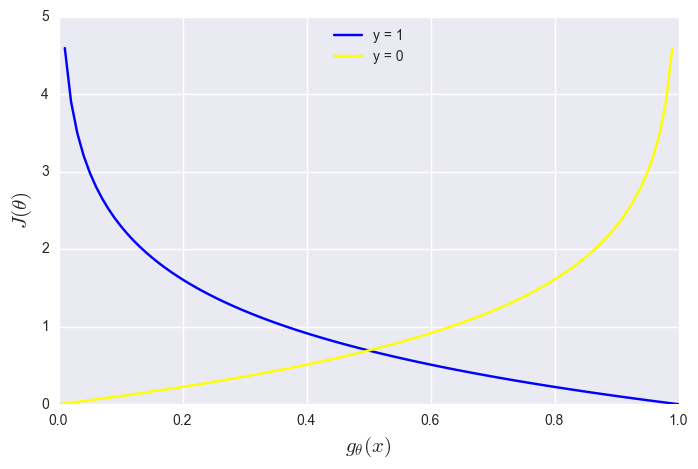

In [15]:
# Visualize the cost function when y = 1 and y = 0
x_vals = np.linspace(0,1,100)
y_1_vals = -np.log(x_vals)
y_0_vals = -np.log(1 - x_vals)

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(x_vals, y_1_vals, color='blue', linestyle='solid', label='y = 1')
ax.plot(x_vals, y_0_vals, color='yellow', linestyle='solid', label='y = 0')
plt.legend(loc='upper center')
plt.xlabel(r'$g_{\theta}(x)$', fontsize=15)
plt.ylabel(r'$J(\theta)$', fontsize=15)
ax.plot

## Exercise 5-2
Can you explain what's happening in the plot above?

In [16]:
y_1_vals

array([        inf,  4.59511985,  3.90197267,  3.49650756,  3.20882549,
        2.98568194,  2.80336038,  2.6492097 ,  2.51567831,  2.39789527,
        2.29253476,  2.19722458,  2.1102132 ,  2.03017049,  1.95606252,
        1.88706965,  1.82253113,  1.76190651,  1.70474809,  1.65068087,
        1.59938758,  1.55059741,  1.5040774 ,  1.45962563,  1.41706602,
        1.37624403,  1.33702331,  1.29928298,  1.26291534,  1.22782402,
        1.19392247,  1.16113265,  1.12938395,  1.09861229,  1.06875933,
        1.03977179,  1.01160091,  0.98420194,  0.95753369,  0.9315582 ,
        0.9062404 ,  0.88154778,  0.85745023,  0.83391973,  0.81093022,
        0.78845736,  0.76647845,  0.74497225,  0.72391884,  0.70329955,
        0.68309684,  0.66329422,  0.64387613,  0.62482794,  0.6061358 ,
        0.58778666,  0.56976816,  0.55206858,  0.53467684,  0.51758241,
        0.50077529,  0.48424599,  0.46798547,  0.45198512,  0.43623677,
        0.42073258,  0.40546511,  0.39042723,  0.37561214,  0.36

In [17]:
y_0_vals

array([-0.        ,  0.01015237,  0.02040887,  0.03077166,  0.04124296,
        0.05182507,  0.06252036,  0.07333127,  0.08426034,  0.09531018,
        0.10648348,  0.11778304,  0.12921173,  0.14077255,  0.15246859,
        0.16430305,  0.17627924,  0.1884006 ,  0.2006707 ,  0.21309322,
        0.225672  ,  0.23841102,  0.25131443,  0.26438651,  0.27763174,
        0.29105476,  0.30466041,  0.31845373,  0.33243997,  0.34662461,
        0.36101335,  0.37561214,  0.39042723,  0.40546511,  0.42073258,
        0.43623677,  0.45198512,  0.46798547,  0.48424599,  0.50077529,
        0.51758241,  0.53467684,  0.55206858,  0.56976816,  0.58778666,
        0.6061358 ,  0.62482794,  0.64387613,  0.66329422,  0.68309684,
        0.70329955,  0.72391884,  0.74497225,  0.76647845,  0.78845736,
        0.81093022,  0.83391973,  0.85745023,  0.88154778,  0.9062404 ,
        0.9315582 ,  0.95753369,  0.98420194,  1.01160091,  1.03977179,
        1.06875933,  1.09861229,  1.12938395,  1.16113265,  1.19

The cost function is designed to penalize misclassification. For each set of parameter values, there will be a cost value over the entire data set. The optimal parameter values are the ones that minimize this cost function. Remember, to think like a machine is to take a problem like this, turn it into a giant optimization problem, and then devise and implement a technique for finding the optimal paramter values (afterall, you can't try every possible combination of $\theta$ values, because that will take longer than the time for the heat death of the universe!).

Of course our technique for finding the right paramater values is going to be gradient descent. But before we get to that, let's implement the cost function.

In [18]:
def logisticCost(X, y, theta):
    # Inputs must be matrices
    # X = m x n (including bias feature of 1 for x0)
    # y = m x 1
    # theta = n x 1
    
    # Number of data points in the dataset
    m = len(X)
    cost_first_term = np.multiply(-y,np.log(sigmoid(X * theta)))
    cost_second_term = np.multiply(1-y, np.log(1 - sigmoid(X * theta)))
    non_normal_term = np.sum(np.subtract(cost_first_term, cost_second_term))
    cost = non_normal_term / m
    
    return cost

In [19]:
# try it out for theta = zeros
logisticCost(X,y,theta)

0.69314718055994529

In [20]:
# try it out for theta = 0.03
logisticCost(X, y, np.matrix([[0.03],[0.03],[0.03]]))

1.3165928742073278

## Steps 6 and 7: Pick an Iterative Method to Minimize the Cost of Getting it Wrong and Implement It
Once again, the method that will "learn" the optimal values for $\theta$ is gradient descent. For logistic regression we have to change our existing gradientDescent function to account for the sigmoid transformation. Otherwise, the expression for gradient descent looks the same as it did before, namely:

$$\frac{\partial J(\theta)}{\partial \theta_{j}} = \frac{1}{m}\sum_{i=1}^{m}(g_{\theta}(x^{(i)}) - y^{(i)}) x_{j}^{(i)}$$

Let's implement this new gradient descent function for logistic regression now.

In [21]:
# BEGIN scratch work
# Doing some scratch work to make sure the matrix multiplication works out
# matrix multiplication is great for computational efficiency
test1 = np.matrix([[1],[2],[3],[4]])

In [22]:
test1

matrix([[1],
        [2],
        [3],
        [4]])

In [23]:
test2 = np.matrix([[1,2,3,4],[1,2,3,4], [1,2,3,4], [1,2,3,4]])

In [24]:
test2

matrix([[1, 2, 3, 4],
        [1, 2, 3, 4],
        [1, 2, 3, 4],
        [1, 2, 3, 4]])

In [25]:
test2 * test1

matrix([[30],
        [30],
        [30],
        [30]])

In [26]:
(test1.T * test2).T

matrix([[10],
        [20],
        [30],
        [40]])

In [27]:
# Right, that's the result we need
# END scratch work

In [28]:
# Gradient Descent for Logistic Regression/Classification
def logisticGradDescent(X, y, theta, alpha, iters):
    # X is a m x n matrix (including a first column of 1s)
    # y is a m x 1 matrix
    # theta is an n x 1 matrix
    # alpha is the learning rate
    # iters is the number of iterations of gradient descent
    
    # Keep track of the evolution of theta and cost values
    theta_agg = theta # initial value of the aggregated array
    cost_vals = logisticCost(X,y,theta) # initial value of cost for the initial theta value
    
    m = len(X)
    
    # Initialize theta for the iter loop below
    theta_val = theta
    
    # Notice there's only 1 loop -- the one over iters -- in this implementation
    for i in range(iters):
        error = np.subtract(sigmoid(X * theta), y)
        sum_error = (error.T * X).T # using the test1, test2 example above
        # no need to explicitly sum the error because the matrix multiplication does it automatically
        # Multiply by alpha and divide by m to normalize the sum_error
        norm_sum_error = np.divide(np.multiply(sum_error, alpha),m)
        # norm_sum_error is an n x 1 matrix containing the correction values for each theta parameter
        
        # Update all the thetas simultaneously
        theta_val = np.subtract(theta_val, norm_sum_error)
        
        # keep track of the latest theta val
        theta_agg = np.c_[theta_agg, theta_val]
        
        # Calculate the cost for these parameter values
        cost_vals = np.c_[cost_vals, logisticCost(X, y, theta_val)]
        
    return theta_agg, cost_vals

In [29]:
# Test it out
theta_out, cost_out = logisticGradDescent(X, y, theta, 0.00001, 100)

In [79]:
#theta_out

In [80]:
#cost_out

In [32]:
cost_out.T.shape

(101, 1)

In [33]:
np.linspace(1,101,101).shape

(101,)

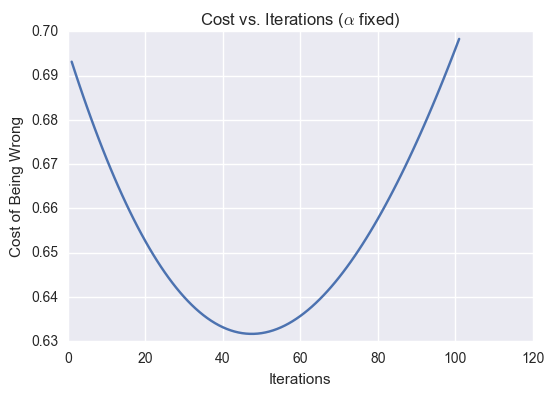

In [202]:
plt.plot(np.linspace(1,101,101), cost_out.T)
plt.title(r'Cost vs. Iterations ($\alpha$ fixed)')
plt.xlabel('Iterations')
plt.ylabel('Cost of Being Wrong')

We see that the gradient descent is sensitive to both alpha and the number of iterations. Better to implement this using an optimization package that is written by experts. The concept is the same the numerical techniques used are super advanced. So let's take advantage of that.

### Finding the Optimal Parameter Values Using Scikit-Learn



In [45]:
from sklearn.linear_model import LogisticRegression

In [192]:
# Solvers that seem to work well are 'liblinear' and 'newton-cg"
lr = LogisticRegression(C=100.0, random_state=0, solver='liblinear', verbose=2)

In [83]:
X_input = data.iloc[:, 1:3].values

In [84]:
y_input = data.iloc[:, 3].values

In [85]:
y_input.shape

(100,)

In [193]:
lr.fit(X_input, y_input)

[LibLinear]

LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=2, warm_start=False)

## Step 8: Results

In [194]:
# Probability of [rejection, admission] for a single set of exam scores
lr.predict_proba(np.array([45, 85]).reshape(1,-1))

array([[ 0.27252389,  0.72747611]])

In [196]:
# Rejected or Admitted?
lr.predict(np.array([45, 45]).reshape(1,-1))

array([0])

In [197]:
# Rejected or Admitted for the entire data set
y_pred = lr.predict(X_input)
print y_pred

[0 0 0 1 1 0 1 0 1 1 1 0 1 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 0 0 1 1 0 0 0 0 1
 1 0 0 1 0 1 1 0 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 0 0 0 0 0 1 0 1 1 0 1 1 1
 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 0 1 1 0 1 1 1 1 1 0 1]


In [198]:
# How do the predictions compare with the actual labels on the data set?
y_input != y_pred

array([False, False, False, False, False, False, False,  True, False,
       False,  True, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False,  True, False, False,
        True, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True, False], dtype=bool)

In [199]:
# How many inputs are misclassified?
print('Misclassified examples: %d' % (y_input != y_pred).sum())

Misclassified examples: 11


In [200]:
# Accuracy of the classifier
from sklearn.metrics import accuracy_score
accuracy_score(y_input, y_pred)

0.89000000000000001

<module 'matplotlib.pyplot' from '/Users/jsubapple/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

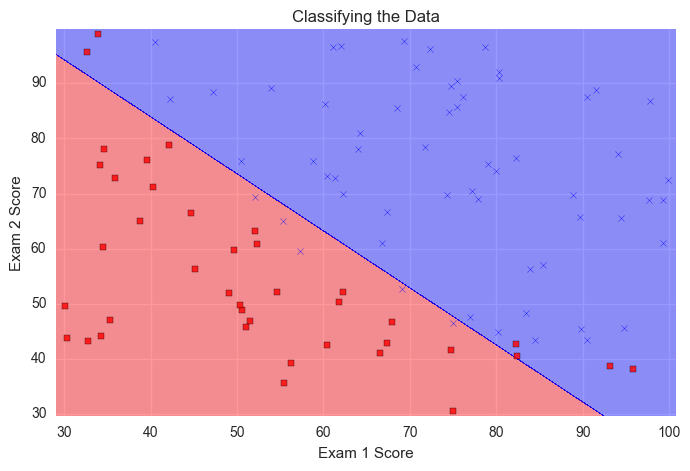

In [201]:
# From the shared functions
plot_decision_regions(X_input, y_input, lr)

So far so good. But what happens when the points we want to classify can't really be separated by a simple boundary like this one? That's when we'll have to construct non-linear boundaries as we'll do in the next chapter.